# Objectives

In this notebook, we work to implement the local fitting scheme but fetching the true vertical locations at the preset x-locations and working with them, only performing a local fit at the end to get the node's final vertical position once its horizontal displacement has been identified.

The easiest way to do this is to choose x-nodes for which the waveform fetching function can directly give the corresponding vertical position; this requires us to put x-nodes on whole numbers between 0 and 576 rather than a numpy.linspace application to preset the x-nodes.

# Why this "FIXED" Notebook 5

In the notebook where noise is introduced on the line example (Notebook 4 FIXED), we observe the following:

If noise is applied on the tagged vertical and horizontal positions before fetching resultant node displacements in the horizontal direction, and if the energy is computed with the same noise applied, the energy evolution is negligibly impacted. However, we saw strong perturbations when we use two different approximation methods for displacement optimization and energy computation.

This motivates a rectification of our procedure with the use of the linear extrapolation and the subsequent local fitting of order 4.

In this notebook, we will only use one fitting method, but not the linear extrapolation which suffered from undefined slope when the segment was near vertical, but instead a 4th degree local approximation on three neighboring points, with an algorithm that changes the selected points if two occupy the same x-coordinate.

In [1]:
import numpy as np
import utils
import evolutionTools as evt
import cv2
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def place_x_nodes(interval, n_nodes):
    start, end = interval
    N = n_nodes
    if N == 1:
        return [start]
    elif N == 2:
        return [start, end]
    
    step = (end - start) // (N - 1)
    
    # Generate nodes
    nodes = [start + i * step for i in range(N)]
    
    # Ensure the last element is exactly the end
    nodes[-1] = end
    
    return np.array(nodes)

In [3]:
place_x_nodes((0, 575), 50)

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 319, 330, 341, 352, 363, 374, 385, 396, 407, 418,
       429, 440, 451, 462, 473, 484, 495, 506, 517, 528, 575])

We now tweak the waveform-fetching function to avoid fitting before solving for the unknown displacements.

In [4]:
def get_upper_waveform(video_name, image_number, OUTPUT = False):   #no path - just number
    image_path = "Data/video"+video_name+"_TREATED/"+"image"+ str(image_number) +".jpg"
    frame = cv2.imread(image_path)
    frame = utils.image_processing(frame) #To get two dimensional array instead of 3 (Grayscale)
    
    waveform = utils.get_waveform(frame) #Upper and Lower surfaces
    upper_surface = waveform[:, 0]

    #plt.plot(np.arange(utils.width), middle_line, label = "middle")     # CAN CHANGE
    #plt.show()
    
    return upper_surface

We now tweak all functions that depend on this function to generate displacements and resultant potentials; we add here the local fitting potential energy function that we want to optimize.

In [5]:
def segment_energy(x_array, y_array, length, k):
    new_distance = evt.euclideanDistance([x_array[0], y_array[0]], [x_array[1], y_array[1]])
    return 0.5 * k * ((length - new_distance)**2)

def potential_energy_2(u_arr, x, y, lengths, k):
    u = np.zeros(x.shape[0])
    for j in range(u_arr.shape[0]):
        u[j+1] = u_arr[j] 
    new_x = x + u
    new_y = np.zeros(y.shape[0])
    for i in range(x.shape[0]):
        min_index = np.max([i - 5, 0])
        max_index = np.min([i+5, x.shape[0] - 1])
        coefficients = np.polyfit(x[min_index:max_index], y[min_index:max_index], 4)
        power = 4
        for c in coefficients:
            new_y[i] += c * (new_x[i] ** power)
            power -= 1
    segment_energies = np.zeros(k.shape[0])
    for l in range(segment_energies.shape[0]):
        segment_energies[l] = segment_energy(new_x[l:l+2], new_y[l:l+2], lengths[l], k[l])
    return np.sum(segment_energies)
    

In [6]:
def potential_energy_3(u_arr, x, y, lengths, k):

    N = u_arr.shape[0]
    
    u = np.zeros(N+2)
    
    for j in range(N):
        u[j+1] = u_arr[j]
    
    new_x_positions = deepcopy(x)
    for i in range(new_x_positions.shape[0]):
        new_x_positions[i] += u[i]
    new_y_nodes = np.zeros(new_x_positions.shape[0])
    for index in range(new_y_nodes.shape[0]):
        min_index = max([index - 5, 0])
        max_index = min([index+5, new_x_positions.shape[0] - 1])
        coefficients = np.polyfit(x[min_index:max_index], y[min_index:max_index], 4)
        new_y_nodes[index] = coefficients[0] * new_x_positions[index]**4
        new_y_nodes[index] += coefficients[1] * new_x_positions[index] ** 3
        new_y_nodes[index] += coefficients[2] * new_x_positions[index] ** 2
        new_y_nodes[index] += coefficients[3] * new_x_positions[index] ** 2
        new_y_nodes[index] += coefficients[4]

    def poten(x_0, y_i, lengths, K):
    
        segmentEnergies = np.zeros(evt.N+1)        #To sum at the end
        x = x_0
        y = y_i
            
        for j in range(K.shape[0]):
            
            
            p1 = (x[j], y[j])
            p2 = (x[j+1], y[j+1])
            
            newDist = evt.euclideanDistance(p1, p2)
            
            segmentEnergies[j] = 0.5 * K[j] * (newDist - lengths[j])**2
        
        return np.sum(segmentEnergies)

    U_pot = poten(new_x_positions, new_x_positions, lengths, k)
    
    
    return U_pot

In [7]:
def get_frame_potential(video_name, image_number, initial_lengths, K_arr, initial_guess = np.zeros(evt.N), x_nodes = None):
    
    waveform = get_upper_waveform(video_name, image_number)
    x_nodes = place_x_nodes((0,575), evt.N + 2) if x_nodes is None else x_nodes
    y_nodes = waveform[x_nodes]
    #print(f'X - Locs: {x_nodes}')
    #print(f'Y - Locs: {y_nodes}')
    #plt.plot(x_nodes, y_nodes)
    #plt.show()

#     plt.figure()
#     plt.plot(x_nodes,y_nodes)
#     plt.show()
    
    displacements = minimize(potential_energy_2, initial_guess, args = (x_nodes, y_nodes, initial_lengths, K_arr))
    #print(f'Displacements: {displacements.x}')
#     print(displacements.x)
#   this is where the local fit is required
# for now ill leave the approximation with the slope lol
#

    U_pot = potential_energy_2(displacements.x, x_nodes, y_nodes, initial_lengths, K_arr)
    
#     plt.figure(figsize=(8,6))
#     plt.plot(x_nodes[1:-1], displacements.x)
#     plt.title(f"Fram: {imageNumber}")
#     plt.show()
    
    
    return U_pot, displacements.x

For now the above function doesn't fit anything at all, but instead computes the resultant energy by using the extrapolation scheme that yields the displacements in the first place.

In [8]:
def potential_evolution(video_name, total_images, increment = 1):   #returns Potential Array (Chronological)
    
    image_number = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = place_x_nodes((0, 575), evt.N +  2)
    
    waveform = get_upper_waveform(video_name, image_number, False)

    y_nodes = waveform[x_nodes]

    new_x = deepcopy(x_nodes)
    new_y = np.zeros(y_nodes.shape[0])
    for i in range(x_nodes.shape[0]):
        min_index = np.max([i - 5, 0])
        max_index = np.min([i+5, x_nodes.shape[0] - 1])
        coefficients = np.polyfit(x_nodes[min_index:max_index], y_nodes[min_index:max_index], 4)
        power = 4
        for c in coefficients:
            new_y[i] += c * (new_x[i] ** power)
            power -= 1
    x_nodes = new_x
    y_nodes = new_y
    initial_lengths = evt.initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(evt.N+1)/(10 * initial_lengths)
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(total_images)
    initial_guess = np.zeros(evt.N)
    #print(initial_lengths)
    displacements = []
    
    while image_number <= total_images:
        
        
        U, new_guess = get_frame_potential(video_name, image_number, initial_lengths, K_arr, initial_guess, x_nodes)
        print(f'Processing Frame: {image_number} - Frame Energy = {U}')
        displacements.append(new_guess)
        U_arr[image_number - 1] = U
        image_number += increment
        initial_guess = new_guess
    
    return U_arr, displacements

In [9]:
energy, displacements = potential_evolution('003HA_Right_20160129_110735.avi', 139, 1)
displacements = np.array(displacements)

Processing Frame: 1 - Frame Energy = 0.0
Processing Frame: 2 - Frame Energy = 0.007701363651044879
Processing Frame: 3 - Frame Energy = 7.940471371328936e-05
Processing Frame: 4 - Frame Energy = 0.01162150789202302
Processing Frame: 5 - Frame Energy = 0.012019491640260248
Processing Frame: 6 - Frame Energy = 5.371008576485267e-07
Processing Frame: 7 - Frame Energy = 0.013650398552096021
Processing Frame: 8 - Frame Energy = 0.007602168554568107
Processing Frame: 9 - Frame Energy = 0.008513271563876917


KeyboardInterrupt: 

In [ ]:
example_data_displacement = pd.DataFrame(displacements) # type: ignore

In [ ]:
example_data_displacement.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_displacements.csv', index = False)

In [ ]:
example_data_energy = pd.DataFrame(energy) # type: ignore

In [ ]:
example_data_energy.to_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_energy.csv', index = False)

In [ ]:
#displacements = pd.read_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_displacements.csv').to_numpy()
#energy = pd.read_csv('local_omitted_fitting_test/003HA_Right_20160129_110735.avi_energy.csv').to_numpy()

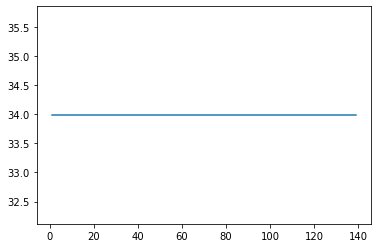

In [ ]:
plt.figure()
plt.plot(np.arange(1,140), energy)
plt.show()